# 1. 데이터셋 생성 및 병합
- 데이터셋 : 2021년도 기준
- 활용 데이터 : 전국 112신고접수 데이터(경찰서별), 서울시 상권분석서비스데이터, 생활안전지도 api 데이터

In [281]:
# package load
import pandas as pd
import numpy as np
from tqdm import tqdm
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# for korean plotting
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# Pandas option
pd.set_option('display.max_columns', None)

## 서울시 지역 정보 데이터

In [282]:
# 서울시 행정동
area_adm = gpd.GeoDataFrame.from_file('data/서울시위치정보/Z_SOP_BND_ADM_DONG_PG.shp', encoding='cp949')
area_adm = area_adm.iloc[:425,:] # 서울 행정동 435개

In [283]:
# 서울시 법정동
area_law = gpd.GeoDataFrame.from_file('data/서울시위치정보/LSMD_ADM_SECT_UMD_11.shp', encoding='cp949')

In [284]:
# 도로정보
seoul_road = gpd.GeoDataFrame.from_file('data/서울시위치정보/Z_KAIS_TL_SPRD_MANAGE_11000.shp', encoding='cp949')
seoul_road = seoul_road[['RN','geometry']]

## 전국 112신고접수 데이터
- 스마트치안빅데이터플랫폼 데이터셋

In [285]:
datals = os.listdir('data/전국112신고접수')
datals.sort()
datals = datals[-13:-1] # 2021년도 데이터

In [286]:
# columns
colnames = pd.read_csv('data/전국112신고접수/columns.csv', encoding='cp949')
colnames = colnames[' 컬럼영문명']
colnames.name = None

In [287]:
# data merge
df_112 = pd.DataFrame(columns=colnames)

for name in datals:
    df_i = pd.read_csv('data/전국112신고접수/'+ name, encoding='utf-8', header=None)
    df_i.columns = colnames
    df_112 = pd.concat([df_112, df_i], axis=0)

df_112 = df_112[df_112.columns.drop(['ACPT_YM'])]

In [288]:
# aggregate
df_112 = df_112.groupby('PLCST_NM', as_index=False).agg('sum')

In [289]:
# 서울 경찰서만 추리기
df_112 = df_112[df_112['PLCST_NM'].str.contains('서울')].reset_index(drop=True)
df_112.head(3)

,PLCST_NM,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,ACPT_EMERG_TYPE_CVAPP,ACPT_EMERG_TYPE_ETC,OCRN_DOTW_SNDD,OCRN_DOTW_MON,OCRN_DOTW_TUE,OCRN_DOTW_WED,OCRN_DOTW_THU,OCRN_DOTW_FRI,OCRN_DOTW_SAT,OCRN_TIZN_00,OCRN_TIZN_01,OCRN_TIZN_02,OCRN_TIZN_03,OCRN_TIZN_04,OCRN_TIZN_05,OCRN_TIZN_06,OCRN_TIZN_07,OCRN_TIZN_08,OCRN_TIZN_09,OCRN_TIZN_10,OCRN_TIZN_11,OCRN_TIZN_12,OCRN_TIZN_13,OCRN_TIZN_14,OCRN_TIZN_15,OCRN_TIZN_16,OCRN_TIZN_17,OCRN_TIZN_18,OCRN_TIZN_19,OCRN_TIZN_20,OCRN_TIZN_21,OCRN_TIZN_22,OCRN_TIZN_23
0,서울강남,125929,64971,31098,29860,0,1124,23192,72898,14709,14006,14075,16097,18115,19040,18970,20897,18735,8030,6194,4422,3195,2641,2128,1703,2062,2714,3536,4366,4715,4727,5201,5449,5752,5424,5729,6222,5921,6240,8243,11746,9569
1,서울강동,96374,48968,26491,20914,1,901,21108,54722,8492,11151,13058,13200,13242,13294,13628,14518,15434,5513,4089,2880,2113,1978,1380,1375,1550,2227,2811,3438,3626,3681,3906,4179,4587,4654,4647,4864,5095,5218,6629,8607,7327
2,서울강북,79765,40683,24067,15015,0,492,17288,46253,6605,9127,11355,10664,10500,11074,11092,12292,12788,4730,3531,2528,1877,1539,1138,1148,1241,1625,2307,2770,2897,2931,3162,3374,3641,3681,3914,4034,4490,4721,5748,7123,5615


## 생활안전지도 데이터
생활안전지도 api에서 추출한(`safemap.ipynb`) 데이터 불러오기
> 범죄 종류 : 살인,강도,강간,절도,폭력,방화,마약,약취유인,도박,전체

In [290]:
df_safety = gpd.GeoDataFrame.from_file('safemap.gpkg')
df_safety = df_safety[df_safety['polc_se'].isin(['03_파출소', '02_지구대'])]
df_safety.columns = ['polc_nm', 'plcstn_nm', 'polc_se', '살인', '강도', '강간', '절도',
       '폭력', '방화', '마약', '약취', '도박', '전체범죄', '시군구',
       'geometry']
df_safety.head(3) # 243 rows

,polc_nm,plcstn_nm,polc_se,살인,강도,강간,절도,폭력,방화,마약,약취,도박,전체범죄,시군구,geometry
0,서울중부,을지로3가,03_파출소,1,1,1,1,2,1,2,1,4,2,중구,POINT (14136777.680 4518316.331)
1,서울중부,을지,02_지구대,5,1,5,4,2,1,4,1,5,4,중구,POINT (14138014.580 4518363.729)
2,서울중부,충무,03_파출소,1,1,1,1,1,1,1,1,1,1,중구,POINT (14136636.970 4517569.513)


In [291]:
df_safety = df_safety.to_crs(epsg=5181) # epsg:5181

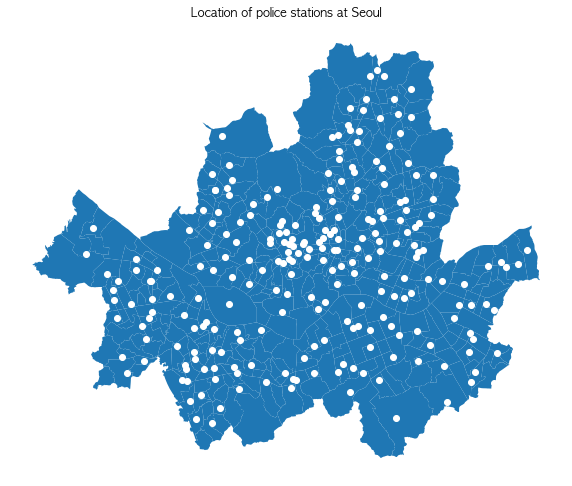

In [292]:
# plot
fig, ax = plt.subplots(figsize = (10,10))
area_adm.geometry.plot(ax=ax, zorder=1)
df_safety.geometry.plot(ax=ax, color='white', zorder = 2) # high zorder > expressed at front layer
plt.axis('off')
plt.title('Location of police stations at Seoul')
plt.show()

## 상권정보
- 서울시 우리마을가게상권분석서비스 데이터 활용

### 상권영역처리

In [293]:
# 상권영역 : 1671
commercial_area = gpd.GeoDataFrame.from_file('data/서울시_우리마을가게_상권분석서비스(신_상권영역)/TBGIS_TRDAR_RELM.shp')
commercial_area = commercial_area[commercial_area.columns.drop(['STDR_YM_CD','TRDAR_SE_C','XCNTS_VALU','YDNTS_VALU'])]

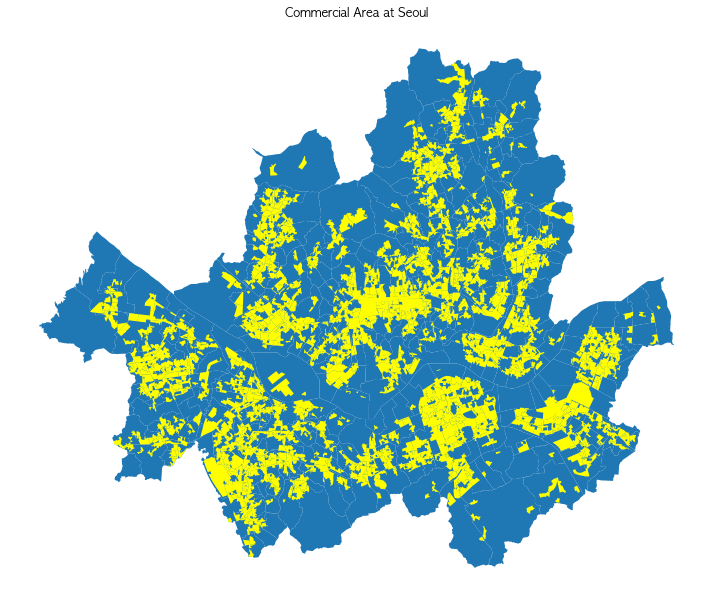

In [294]:
# plot
fig, ax = plt.subplots(figsize = (10,10))
area_adm.geometry.plot(ax=ax, zorder=1)
commercial_area.geometry.plot(ax=ax, color='yellow', zorder = 2) # high zorder > expressed at front layer
plt.axis('off')
plt.title('Commercial Area at Seoul')
plt.tight_layout()
plt.show()

In [295]:
df_safety['112신고'] = 0

for i in tqdm(range(len(df_safety))):
    pol_stn_i = df_safety.at[i, 'polc_nm']
    df_safety.at[i,'112신고'] = df_112.loc[df_112['PLCST_NM']==pol_stn_i, 'RPRT_CASCNT_WHOL']

100%|██████████| 243/243 [00:00<00:00, 9217.42it/s]


#### 각 상권 중심점에서 가장 가까운 지구대/파출소 찾기

In [296]:
# 각 상권 중심점에서 가장 가까운 지구대/파출소 찾기
centers = commercial_area.geometry.centroid # 각 상권 중심점 좌표
commercial_area['nearest_pol_idx'] = 0 # 가장 가까운 지구대/파출소 index from df_safety

for i in tqdm(range(len(commercial_area))):
    dist_i = df_safety.geometry.distance(centers[i])
    idx_i = np.argmin(dist_i)
    commercial_area.at[i,'nearest_pol_idx'] = idx_i

100%|██████████| 1671/1671 [00:01<00:00, 1119.13it/s]


In [297]:
len(commercial_area.nearest_pol_idx.unique()) # 238개 지구대/파출소 선정됨

238

### 생활인구(유동인구) 데이터 처리

In [298]:
# 생활인구 : 1668 * 4분기
df_pop = pd.read_csv('data/서울시 우리마을가게 상권분석서비스(상권-생활인구).csv', encoding='cp949')
df_pop = df_pop[df_pop['기준 년코드']==2021]
df_pop = df_pop[df_pop.columns.drop(['기준 년코드','기준_분기_코드','상권_구분_코드',' 상권_구분_코드_명', '상권_코드_명'])]

In [299]:
# 생활인구 분기별 > 연도별 총합(aggregation with sum)
df_pop = df_pop.groupby('상권_코드', as_index=False).agg('sum')
df_pop.head(3)

,상권_코드,총_생활인구_수,남성_생활인구_수,여성_생활인구_수,연령대_10_생활인구_수,연령대_20_생활인구_수,연령대_30_생활인구_수,연령대_40_생활인구_수,연령대_50_생활인구_수,연령대_60_이상_생활인구_수,시간대_1_생활인구_수,시간대_2_생활인구_수,시간대_3_생활인구_수,시간대_4_생활인구_수,시간대_5_생활인구_수,시간대_6_생활인구_수,월요일_생활인구_수,화요일_생활인구_수,수요일_생활인구_수,목요일_생활인구_수,금요일_생활인구_수,토요일_생활인구_수,일요일_생활인구_수,남성연령대_10_월요일시간대_1_생활인구_수,남성연령대_10_월요일시간대_2_생활인구_수,남성연령대_10_월요일시간대_3_생활인구_수,남성연령대_10_월요일시간대_4_생활인구_수,남성연령대_10_월요일시간대_5_생활인구_수,남성연령대_10_월요일시간대_6_생활인구_수,남성연령대_10_화요일시간대_1_생활인구_수,남성연령대_10_화요일시간대_2_생활인구_수,남성연령대_10_화요일시간대_3_생활인구_수,남성연령대_10_화요일시간대_4_생활인구_수,남성연령대_10_화요일시간대_5_생활인구_수,남성연령대_10_화요일시간대_6_생활인구_수,남성연령대_10_수요일시간대_1_생활인구_수,남성연령대_10_수요일시간대_2_생활인구_수,남성연령대_10_수요일시간대_3_생활인구_수,남성연령대_10_수요일시간대_4_생활인구_수,남성연령대_10_수요일시간대_5_생활인구_수,남성연령대_10_수요일시간대_6_생활인구_수,남성연령대_10_목요일시간대_1_생활인구_수,남성연령대_10_목요일시간대_2_생활인구_수,남성연령대_10_목요일시간대_3_생활인구_수,남성연령대_10_목요일시간대_4_생활인구_수,남성연령대_10_목요일시간대_5_생활인구_수,남성연령대_10_목요일시간대_6_생활인구_수,남성연령대_10_금요일시간대_1_생활인구_수,남성연령대_10_금요일시간대_2_생활인구_수,남성연령대_10_금요일시간대_3_생활인구_수,남성연령대_10_금요일시간대_4_생활인구_수,남성연령대_10_금요일시간대_5_생활인구_수,남성연령대_10_금요일시간대_6_생활인구_수,남성연령대_10_토요일시간대_1_생활인구_수,남성연령대_10_토요일시간대_2_생활인구_수,남성연령대_10_토요일시간대_3_생활인구_수,남성연령대_10_토요일시간대_4_생활인구_수,남성연령대_10_토요일시간대_5_생활인구_수,남성연령대_10_토요일시간대_6_생활인구_수,남성연령대_10_일요일시간대_1_생활인구_수,남성연령대_10_일요일시간대_2_생활인구_수,남성연령대_10_일요일시간대_3_생활인구_수,남성연령대_10_일요일시간대_4_생활인구_수,남성연령대_10_일요일시간대_5_생활인구_수,남성연령대_10_일요일시간대_6_생활인구_수,남성연령대_20_월요일시간대_1_생활인구_수,남성연령대_20_월요일시간대_2_생활인구_수,남성연령대_20_월요일시간대_3_생활인구_수,남성연령대_20_월요일시간대_4_생활인구_수,남성연령대_20_월요일시간대_5_생활인구_수,남성연령대_20_월요일시간대_6_생활인구_수,남성연령대_20_화요일시간대_1_생활인구_수,남성연령대_20_화요일시간대_2_생활인구_수,남성연령대_20_화요일시간대_3_생활인구_수,남성연령대_20_화요일시간대_4_생활인구_수,남성연령대_20_화요일시간대_5_생활인구_수,남성연령대_20_화요일시간대_6_생활인구_수,남성연령대_20_수요일시간대_1_생활인구_수,남성연령대_20_수요일시간대_2_생활인구_수,남성연령대_20_수요일시간대_3_생활인구_수,남성연령대_20_수요일시간대_4_생활인구_수,남성연령대_20_수요일시간대_5_생활인구_수,남성연령대_20_수요일시간대_6_생활인구_수,남성연령대_20_목요일시간대_1_생활인구_수,남성연령대_20_목요일시간대_2_생활인구_수,남성연령대_20_목요일시간대_3_생활인구_수,남성연령대_20_목요일시간대_4_생활인구_수,남성연령대_20_목요일시간대_5_생활인구_수,남성연령대_20_목요일시간대_6_생활인구_수,남성연령대_20_금요일시간대_1_생활인구_수,남성연령대_20_금요일시간대_2_생활인구_수,남성연령대_20_금요일시간대_3_생활인구_수,남성연령대_20_금요일시간대_4_생활인구_수,남성연령대_20_금요일시간대_5_생활인구_수,남성연령대_20_금요일시간대_6_생활인구_수,남성연령대_20_토요일시간대_1_생활인구_수,남성연령대_20_토요일시간대_2_생활인구_수,남성연령대_20_토요일시간대_3_생활인구_수,남성연령대_20_토요일시간대_4_생활인구_수,남성연령대_20_토요일시간대_5_생활인구_수,남성연령대_20_토요일시간대_6_생활인구_수,남성연령대_20_일요일시간대_1_생활인구_수,남성연령대_20_일요일시간대_2_생활인구_수,남성연령대_20_일요일시간대_3_생활인구_수,남성연령대_20_일요일시간대_4_생활인구_수,남성연령대_20_일요일시간대_5_생활인구_수,남성연령대_20_일요일시간대_6_생활인구_수,남성연령대_30_월요일시간대_1_생활인구_수,남성연령대_30_월요일시간대_2_생활인구_수,남성연령대_30_월요일시간대_3_생활인구_수,남성연령대_30_월요일시간대_4_생활인구_수,남성연령대_30_월요일시간대_5_생활인구_수,남성연령대_30_월요일시간대_6_생활인구_수,남성연령대_30_화요일시간대_1_생활인구_수,남성연령대_30_화요일시간대_2_생활인구_수,남성연령대_30_화요일시간대_3_생활인구_수,남성연령대_30_화요일시간대_4_생활인구_수,남성연령대_30_화요일시간대_5_생활인구_수,남성연령대_30_화요일시간대_6_생활인구_수,남성연령대_30_수요일시간대_1_생활인구_수,남성연령대_30_수요일시간대_2_생활인구_수,남성연령대_30_수요일시간대_3_생활인구_수,남성연령대_30_수요일시간대_4_생활인구_수,남성연령대_30_수요일시간대_5_생활인구_수,남성연령대_30_수요일시간대_6_생활인구_수,남성연령대_30_목요일시간대_1_생활인구_수,남성연령대_30_목요일시간대_2_생활인구_수,남성연령대_30_목요일시간대_3_생활인구_수,남성연령대_30_목요일시간대_4_생활인구_수,남성연령대_30_목요일시간대_5_생활인구_수,남성연령대_30_목요일시간대_6_생활인구_수,남성연령대_30_금요일시간대_1_생활인구_수,남성연령대_30_금요일시간대_2_생활인구_수,남성연령대_30_금요일시간대_3_생활인구_수,남성연령대_30_금요일시간대_4_생활인구_수,남성연령대_30_금요일시간대_5_생활인구_수,남성연령대_30_금요일시간대_6_생활인구_수,남성연령대_30_토요일시간대_1_생활인구_수,남성연령대_30_토요일시간대_2_생활인구_수,남성연령대_30_토요일시간대_3_생활인구_수,남성연령대_30_토요일시간대_4_생활인구_수,남성연령대_30_토요일시간대_5_생활인구_수,남성연령대_30_토요일시간대_6_생활인구_수,남성연령대_30_일요일시간대_1_생활인구_수,남성연령대_30_일요일시간대_2_생활인구_수,남성연령대_30_일요일시간대_3_생활인구_수,남성연령대_30_일요일시간대_4_생활인구_수,남성연령대_30_일요일시간대_5_생활인구_수,남성연령대_30_일요일시간대_6_생활인구_수,남성연령대_40_월요일시간대_1_생활인구_수,남성연령대_40_월요일시간대_2_생활인구_수,남성연령대_40_월요일시간대_3_생활인구_수,남성연령대_40_월요일시간대_4_생활인구_수,남성연령대_40_월요일시간대_5_생활인구_수,남성연령대_40_월요일시간대_6_생활인구_수,남성연령대_40_화요일시간대_1_생활인구_수,남성연령대_40_화요일시간대_2_생활인구_수,남성연령대_40_화요일시간대_3_생활인구_수,남성연령대_40_화요일시간대_4_생활인구_수,남성연령대_40_화요일시간대_5_생활인구_수,남성연령대_40_화요일시간대_6_생활인구_수,남성연령대_40_수요일시간대_1_생활인구_수,남성연령대_40_수요일시간대_2_생활인구_수,남성연령대_40_수요일시간대_3_생활인구_수,남성연령대_40_수요일시간대_4_생활인구_수,남성연령대_40_수요일시간대_5_생활인구_수,남성연령대_40_수요일시간대_6_생활인구_수,남성연령대_40_목요일시간대_1_생활인구_수,남성연령대_40_목요일시간대_2_생활인구_수,남성연령대_40_목요일시간대_3_생활인구_수,남성연령대_40_목요일시간대_4_생활인구_수,남성연령대_40_목요일시간대_5_생활인구

### 상권 인근 아파트 데이터
상권 인근의 아파트 단지 수 및 평균 시가 정보

In [300]:
# 상권_아파트 > 아파트 단지수와 평균시가만 사용 > aggregate
df_apt = pd.read_csv('data/서울시 우리마을가게 상권분석서비스(상권-아파트).csv', encoding='cp949', usecols=['상권_코드','아파트_단지_수','아파트_평균_시가'])
df_apt = df_apt.groupby('상권_코드', as_index=False).agg({'아파트_단지_수' : 'max', '아파트_평균_시가' : 'mean'}).round(0)
df_apt.head(3)

,상권_코드,아파트_단지_수,아파트_평균_시가
0,1001491,71,396684548.0
1,1001493,11,247400571.0
2,1001494,8,111028306.0


### 상권내 점포 데이터(n=1665)
- 상권의 2021년도 점포수를 기준으로 개업률, 폐업률 및 프랜차이즈 침투율 계산
- 요식업비율 계산

In [301]:
# 점포 정보 : 1665개
df_store = pd.read_csv('data/서울시_우리마을가게_상권분석서비스(신_상권_점포)_2021년.csv', encoding='cp949')


In [302]:
code_res = ['한식음식점', '분식전문점', '호프-간이주점', '커피-음료', '양식음식점','제과점', '치킨전문점','일식음식점','패스트푸드점','중식음식점']

In [303]:
df_store['요식업'] = np.where(df_store['서비스_업종_코드_명'].isin(code_res), '요식업', '비요식업')

In [304]:
df_store = df_store[['기준_분기_코드','상권_코드', '점포_수', '개업_점포_수', '폐업_점포_수', '프랜차이즈_점포_수','요식업']]

In [305]:
# 분기별로 sum aggregate
df_store = df_store.groupby(by=['기준_분기_코드','상권_코드','요식업'],as_index=False).agg('sum')

In [306]:
# 점포수 기준은 1분기로 하여 개업율, 폐업율, 프랜차이즈 침투율 게산
df_store = df_store.groupby(by=['상권_코드','요식업'], as_index=False).agg(
    {'점포_수' : lambda x: x.iloc[0], '개업_점포_수' : 'sum', '폐업_점포_수' : 'sum', '프랜차이즈_점포_수' : 'sum'}
    )
df_store.head(3)

,상권_코드,요식업,점포_수,개업_점포_수,폐업_점포_수,프랜차이즈_점포_수
0,1001491,비요식업,1052,64,62,132
1,1001491,요식업,581,108,117,198
2,1001492,비요식업,7164,245,520,855


In [307]:
# Pivotting
df_store = df_store.pivot_table(index='상권_코드',values=['점포_수','개업_점포_수','폐업_점포_수','프랜차이즈_점포_수'],columns='요식업')

In [308]:
df_store.columns = df_store.columns.to_flat_index().map('_'.join)

### 추정매출(n=1651)
> 총 매출액 및 매출건수만 추출

In [309]:
df_sales = pd.read_csv('data/서울시_우리마을가게_상권분석서비스(신_상권_추정매출)_2021년.csv', encoding='cp949')
df_sales = df_sales[['상권_코드','분기당_매출_금액','분기당_매출_건수']]

In [310]:
df_sales = df_sales.groupby(by='상권_코드', as_index=False).agg('sum')
df_sales.columns = ['상권_코드','매출액','매출건수']
df_sales.head(3)

,상권_코드,매출액,매출건수
0,1001491,344400344893,10973574
1,1001492,1351039278617,48148842
2,1001493,834882004415,31741353


## 상권내/인근 버스정류장 및 지하철역 개수 정보
버스정류장 : 상권 내 혹은 상권으로부터 100M 이내 정류장 개수</br>
지하철역 : 상권으로부터 500M 이내 역 개수

In [311]:
# 버스정류장
df_bus = pd.read_csv('data/busstops.csv', encoding='cp949')
gdf_bus = gpd.GeoDataFrame(df_bus, geometry=gpd.points_from_xy(x=df_bus['X좌표'], y=df_bus['Y좌표'], crs='WGS84'))
gdf_bus = gdf_bus.to_crs(epsg=5181)

In [312]:
# 지하철역
df_sub = pd.read_csv('data/station_coordinate.csv', encoding='utf-8')
gdf_sub = gpd.GeoDataFrame(df_sub, geometry=gpd.points_from_xy(x=df_sub.lng, y=df_sub.lat, crs='WGS84'))
gdf_sub = gdf_sub.to_crs(epsg=5181)

In [313]:
# Count(2min)
commercial_area['Bus'] = 0
commercial_area['Subway'] = 0

for i in tqdm(range(len(commercial_area))):
    # distance function
    bus_i = np.where(gdf_bus.geometry.distance(commercial_area.geometry[i])<100.0)[0] # 1D array
    sub_i = np.where(gdf_sub.geometry.distance(commercial_area.geometry[i])<500.0)[0] # 1D array
    commercial_area.at[i,'Bus'] = len(bus_i)
    commercial_area.at[i,'Subway'] = len(sub_i)

commercial_area.head(3)

100%|██████████| 1671/1671 [01:25<00:00, 19.50it/s]


,TRDAR_SE_1,TRDAR_NO,TRDAR_NM,SIGNGU_CD,ADSTRD_CD,geometry,nearest_pol_idx,Bus,Subway
0,골목상권,2110753,시흥동 은행나무사거리,11545,11545710,"POLYGON ((192008.560 438553.170, 191987.740 43...",125,28,0
1,골목상권,2110427,노원 을지대학교병원,11350,11350611,"POLYGON ((206296.880 459321.710, 206238.710 45...",145,6,1
2,골목상권,2110755,동일여자고등학교,11545,11545680,"POLYGON ((192443.040 439028.230, 192507.940 43...",125,19,0


## 서울시 상업용 부동산 실거래가 데이터
상권별 평균 m^2당 거래금액(각 거래건별 제곱미터당 가격들의 상권전역평균) 및 평균조절가격(`assetprice.ipynb`) 도출

In [314]:
# real estate data load
df_re = pd.read_csv('data/국토교통부 실거래가.csv', encoding='utf-8', usecols = ['도로명','전용/연면적(㎡)','거래금액(만원)','층','건축년도','건축물주용도'])
df_re.columns= ['도로명','건축물주용도','전용면적','거래금액','1층유무','건축년도']  # type: ignore
df_re = df_re.loc[df_re.건축물주용도.isin(['제2종근린생활','제1종근린생활','판매']),:] # 숙박, 업무용시설 등 부동산은 제외
df_re = df_re.dropna(axis=0).reset_index(drop=True)
df_re.shape

(6720, 6)

In [315]:
# 1층 외 나머지층 구분
df_re['1층유무'] = np.where(df_re['1층유무']==1, 1, 0)

### Dtype

In [316]:
# 거래금액 to float
for i in range(len(df_re)):
    df_re.at[i,'거래금액'] = df_re.at[i,'거래금액'].replace(',','',-1)

df_re['거래금액'] = df_re['거래금액'].astype('float')

df_re['건축년도'] = df_re['건축년도'].astype('int')

df_re['건축년도'] = 2021-df_re['건축년도'] # 2021년기준 건물 연식

In [317]:
df_re = pd.concat([df_re.drop('건축물주용도',axis=1),pd.get_dummies(df_re.건축물주용도, drop_first=True)], axis=1)

In [318]:
# 면적당 거래금액으로 환산
df_re['면적당금액'] = df_re['거래금액'] / df_re['전용면적']

#### 조절거래가
> 각 부동산 거래내역별 유의미한 회귀계수를 반영하여 조절거래가 변수 생성

In [319]:
# 조절거래가
df_re['조절거래가'] = np.log(df_re.거래금액) - 0.0033 * df_re['전용면적'] - 0.2041 * df_re['1층유무'] - (-0.0069) * df_re['건축년도'] - (-0.5749) * df_re['판매'] - (-0.0578) * df_re['제2종근린생활']

In [320]:
# Setting
commercial_area['매매거래가내역'] = [[] for _ in range(len(commercial_area))]
commercial_area['조절거래가내역'] = [[] for _ in range(len(commercial_area))]
commercial_area['평균매매가'] = 0.0
commercial_area['평균조절가'] = 0.0

### Count

In [321]:
# Count-평균매매가/조절가 (2.5min)
for i in tqdm(range(len(df_re))):
    price_i = df_re.at[i,'면적당금액'] # i번째 거래데이터의 면적당금액
    adprice_i = df_re.at[i, '조절거래가'] # 조절거래가

    arr_i = np.where(seoul_road.RN == df_re.at[i,'도로명'])[0] # 해당 부동산이 속한 도로의 geometry 얻기

    if len(arr_i) == 0:
        pass
    elif len(arr_i) == 1:
        road_i = seoul_road.at[arr_i[0],'geometry']
    else:
        road_i = seoul_road.iloc[arr_i,:].unary_union

    # 도로를 포함하는 모든 상권영역    
    area_idx_i = np.where(commercial_area.geometry.intersects(road_i))[0]
    if len(area_idx_i) == 0:
        pass
    elif len(area_idx_i) == 1:
        commercial_area.at[area_idx_i[0], '매매거래가내역'].append(price_i)
        commercial_area.at[area_idx_i[0], '조절거래가내역'].append(adprice_i)
    else:
        for j in area_idx_i:
            commercial_area.at[j, '매매거래가내역'].append(price_i)
            commercial_area.at[j, '조절거래가내역'].append(adprice_i)

100%|██████████| 6720/6720 [02:26<00:00, 45.94it/s] 


### Calculate Mean

In [322]:
for i in tqdm(range(len(commercial_area))):
    ls_i = commercial_area.at[i, '매매거래가내역']
    adls_i = commercial_area.at[i, '조절거래가내역']
    if len(ls_i) > 0 :
        commercial_area.at[i, '평균매매가'] = np.mean(ls_i)
        commercial_area.at[i, '평균조절가'] = np.mean(adls_i)
    else:
        pass

100%|██████████| 1671/1671 [00:00<00:00, 50521.76it/s]


In [323]:
commercial_area.head(3)

,TRDAR_SE_1,TRDAR_NO,TRDAR_NM,SIGNGU_CD,ADSTRD_CD,geometry,nearest_pol_idx,Bus,Subway,매매거래가내역,조절거래가내역,평균매매가,평균조절가
0,골목상권,2110753,시흥동 은행나무사거리,11545,11545710,"POLYGON ((192008.560 438553.170, 191987.740 43...",125,28,0,"[466.64362253715865, 716.9576059850374, 654.61...","[10.026454144986467, 9.368770314351341, 9.2777...",481.630544,9.424304
1,골목상권,2110427,노원 을지대학교병원,11350,11350611,"POLYGON ((206296.880 459321.710, 206238.710 45...",145,6,1,[320.63492063492066],[9.388040702829352],320.634921,9.388041
2,골목상권,2110755,동일여자고등학교,11545,11545680,"POLYGON ((192443.040 439028.230, 192507.940 43...",125,19,0,"[500.5382131324004, 354.3586109142452, 261.584...","[10.606237591575447, 8.998514371976183, 8.7087...",420.166575,8.926389


## 서울시 유흥업소 정보
스마트치안빅데이터플랫폼의 **도시구분과 관서별 유흥시설 데이터(LH)** 활용 </br>
> 전국단위 데이터이므로 서울시 경찰관서 관내로 한정(2711개)

In [324]:
df_bars = gpd.GeoDataFrame.from_file('data/KLH_15_20211115_G_001/KLH_15_20211115_G_001.shp')
df_bars = df_bars[df_bars.PS_NM.str.startswith('서울')]
df_bars = df_bars[['PS_NM','PSS_NM','geometry']].reset_index(drop=True)

In [325]:
# 각 상권 내에 포함된 유흥업소 개수 count(10s)
commercial_area['유흥업소'] = 0

for i in tqdm(range(len(commercial_area))):
    # within function
    bar_i = np.where(df_bars.geometry.within(commercial_area.geometry[i]))[0] # 1D array
    commercial_area.at[i,'유흥업소'] = len(bar_i)

commercial_area.head(3)

100%|██████████| 1671/1671 [00:05<00:00, 290.51it/s]


,TRDAR_SE_1,TRDAR_NO,TRDAR_NM,SIGNGU_CD,ADSTRD_CD,geometry,nearest_pol_idx,Bus,Subway,매매거래가내역,조절거래가내역,평균매매가,평균조절가,유흥업소
0,골목상권,2110753,시흥동 은행나무사거리,11545,11545710,"POLYGON ((192008.560 438553.170, 191987.740 43...",125,28,0,"[466.64362253715865, 716.9576059850374, 654.61...","[10.026454144986467, 9.368770314351341, 9.2777...",481.630544,9.424304,4
1,골목상권,2110427,노원 을지대학교병원,11350,11350611,"POLYGON ((206296.880 459321.710, 206238.710 45...",145,6,1,[320.63492063492066],[9.388040702829352],320.634921,9.388041,0
2,골목상권,2110755,동일여자고등학교,11545,11545680,"POLYGON ((192443.040 439028.230, 192507.940 43...",125,19,0,"[500.5382131324004, 354.3586109142452, 261.584...","[10.606237591575447, 8.998514371976183, 8.7087...",420.166575,8.926389,0


## 데이터 병합

In [326]:
# commercial area code as index
from copy import deepcopy

df_final = deepcopy(commercial_area.set_index('TRDAR_NO'))
df_final.index = df_final.index.astype('int')

In [327]:
df_final[['살인', '강도', '강간', '절도',
       '폭력', '방화', '마약', '약취', '도박', '전체범죄','112신고']] = 0

In [328]:
# 생활안전지도 데이터 병합
df_final[['살인', '강도', '강간', '절도',
       '폭력', '방화', '마약', '약취', '도박', '전체범죄','112신고']] = 0

for idx in tqdm(df_final.index):
    pol_idx = df_final.at[idx,'nearest_pol_idx']
    df_final.loc[idx, ['살인', '강도', '강간', '절도', '폭력', '방화', '마약', '약취', '도박', '전체범죄','112신고']] = deepcopy(df_safety.loc[
       pol_idx, ['살인', '강도', '강간', '절도', '폭력', '방화', '마약', '약취', '도박', '전체범죄','112신고']])

100%|██████████| 1671/1671 [00:00<00:00, 1689.89it/s]


In [329]:
# 유동인구
# 요일별로 나타난 유동인구는 불필요하여 제외
target_cols_pop = df_pop.columns[~df_pop.columns.str.contains('요일')]
df_final = df_final.join(df_pop[target_cols_pop].set_index('상권_코드'))

In [330]:
# 아파트
df_final = df_final.join(df_apt.set_index('상권_코드'))

In [331]:
# 점포정보
df_final = df_final.join(df_store)


In [332]:
# 추정매출
df_final = df_final.join(df_sales.set_index('상권_코드'))

## 최종 데이터셋

In [333]:
df_final = df_final.drop(['매매거래가내역','조절거래가내역'], axis=1)

In [334]:
df_final.to_file('df_final.gpkg', index=False)